# Analisis y gestion de nulos de las columnas categoricas (4)

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x : '%.4f' % x) # Mostrar 4 decimales en los outputs
import sys
sys.path.append('..')
#Paquetes de visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
#Importaciones de soporte
from src import sp_eda as sp
from src import sp_visualizacion as spv
from src import sp_nulos_num as snulos

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
df = pd.read_csv('../data/data_limpios.csv')  # Cargamos el dataset
df.head()

,campaign_id,company,campaign_type,target_audience,duration,channel_used,conversion_rate,roi,location,language,clicks,impressions,engagement_score,customer_segment,date,total($),genre,ages,year,month,day_name,quarter
0,1,innovate_industries,unknown,men_18-24,30.0000,google_ads,0.0404,6.2900,chicago,spanish,NaN,19221922.0000,66.0000,health_&_wellness,2021-01-01,16174.0000,men,18-24,2021.0000,1.0000,friday,1.0000
1,2,nexgen_systems,email,women_35-44,60.0000,google_ads,0.1212,5.6100,new_york,german,116.0000,7523.0000,7.0000,fashionistas,2021-01-02,11566.0000,women,35-44,2021.0000,1.0000,saturday,1.0000
2,3,alpha_innovations,influencer,men_25-34,30.0000,youtube,0.0707,7.1800,los_angeles,french,NaN,7698.0000,11.0000,outdoor_adventurers,2021-01-03,10200.0000,men,25-34,2021.0000,1.0000,sunday,1.0000
3,4,unknown,display,all_ages,60.0000,youtube,0.1111,NaN,miami,mandarin,217.0000,NaN,7.0000,health_&_wellness,2021-01-04,12724.0000,all,ages,2021.0000,1.0000,monday,1.0000
4,5,nexgen_systems,email,men_25-34,15.0000,youtube,0.0505,66.5500,los_angeles,unknown,379379.0000,4201.0000,33.0000,health_&_wellness,2021-01-05,16452.0000,men,25-34,2021.0000,1.0000,tuesday,1.0000


In [4]:
df.describe().T # Resumen estadístico de las variables numéricas

,count,mean,std,min,25%,50%,75%,max
campaign_id,209915.0000,100015.0741,57747.9842,1.0000,50013.5000,100018.0000,150065.5000,200000.0000
duration,191309.0000,37.5035,16.7443,15.0000,30.0000,30.0000,45.0000,60.0000
conversion_rate,200471.0000,0.0808,0.0410,0.0100,0.0500,0.0808,0.1200,0.1515
roi,173439.0000,27.5304,26.1923,2.0000,5.0100,8.0000,55.0000,88.0000
clicks,178641.0000,275083.8650,330318.3401,100.0000,551.0000,100100.0000,548548.0000,999999.0000
impressions,188453.0000,27542118.3142,33097499.8431,1000.0000,5508.0000,9996.0000,55225522.0000,99999999.0000
engagement_score,186051.0000,77.9064,215.8253,1.0000,5.0000,10.0000,66.0000,1010.0000
total($),201832.0000,12503.9995,4338.1943,5000.0000,8740.0000,12496.0000,16261.0000,20000.0000
year,203007.0000,2021.0000,0.0000,2021.0000,2021.0000,2021.0000,2021.0000,2021.0000
month,203007.0000,6.5275,3.4465,1.0000,4.0000,7.0000,10.0000,12.0000


In [5]:
# Nos quedamos con las columnas numéricas que tienen sentido en el análisis
columnas_num = df.select_dtypes(include = [np.number]).columns.tolist() # Seleccionamos las columnas numéricas
lista_eliminar = ['campaign_id', 'year', 'month', 'quarter'] # columnas que no queremos en el análisis y vamos a eliminar
for col in lista_eliminar:
  columnas_num.remove(col)
columnas_num

['duration',
 'conversion_rate',
 'roi',
 'clicks',
 'impressions',
 'engagement_score',
 'total($)']

In [6]:
df[columnas_num].describe().T # Resumen estadístico de las variables numéricas

,count,mean,std,min,25%,50%,75%,max
duration,191309.0000,37.5035,16.7443,15.0000,30.0000,30.0000,45.0000,60.0000
conversion_rate,200471.0000,0.0808,0.0410,0.0100,0.0500,0.0808,0.1200,0.1515
roi,173439.0000,27.5304,26.1923,2.0000,5.0100,8.0000,55.0000,88.0000
clicks,178641.0000,275083.8650,330318.3401,100.0000,551.0000,100100.0000,548548.0000,999999.0000
impressions,188453.0000,27542118.3142,33097499.8431,1000.0000,5508.0000,9996.0000,55225522.0000,99999999.0000
engagement_score,186051.0000,77.9064,215.8253,1.0000,5.0000,10.0000,66.0000,1010.0000
total($),201832.0000,12503.9995,4338.1943,5000.0000,8740.0000,12496.0000,16261.0000,20000.0000


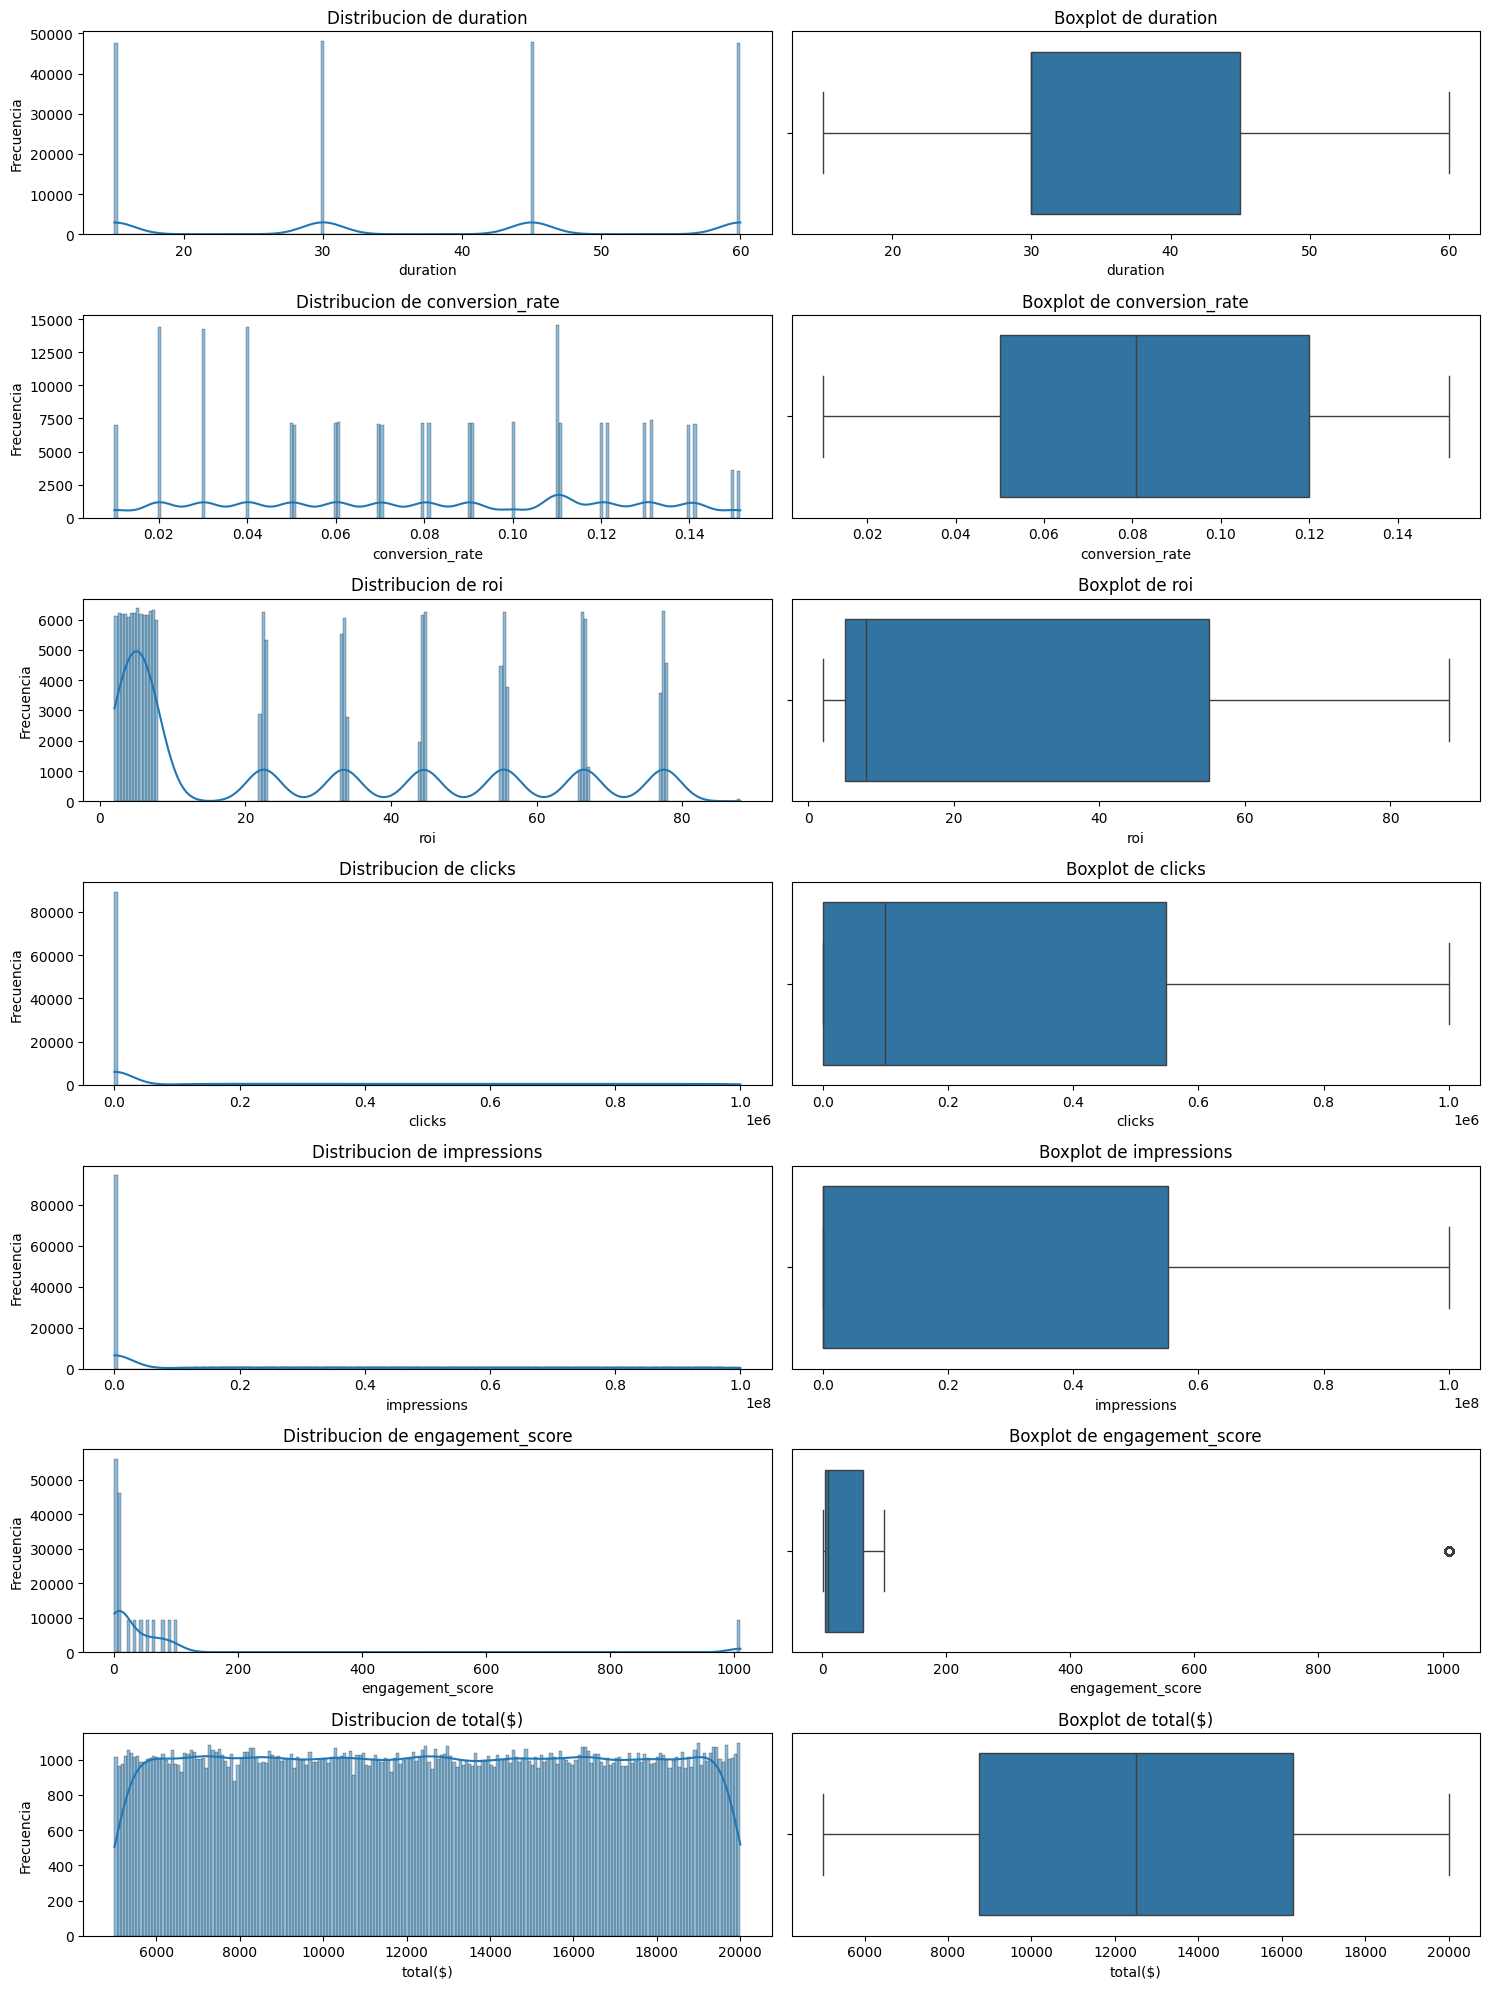

In [7]:
spv.subplot_col_num(df, columnas_num)

In [8]:
dicc_outliers = {'impressions': 800000000, 
                 'clicks': 8000000,
                 'engagement_score': 800}
# Filtramos los outliers de las columnas numéricas que hemos seleccionado anteriormente

In [9]:
for col, out in dicc_outliers.items():
  outliers = df[col][df[col]>out].count() # Eliminamos los registros con valores atípicos
  print(f'Para la columna {col.upper()} tenemos {outliers} outliers, lo que representa un {round(outliers/df.shape[0]*100, 3)}% del total de los datos')

Para la columna IMPRESSIONS tenemos 0 outliers, lo que representa un 0.0% del total de los datos
Para la columna CLICKS tenemos 0 outliers, lo que representa un 0.0% del total de los datos
Para la columna ENGAGEMENT_SCORE tenemos 9284 outliers, lo que representa un 4.423% del total de los datos


In [10]:
df['clicks'] = df['clicks'].apply(lambda x : np.nan if x > 8000000 else x) # Eliminamos los registros con valores atípicos
df['impressions'] = df['impressions'].apply(lambda x : np.nan if x > 800000000 else x) # Eliminamos los registros con valores atípicos

## Analizamos las columnas numericas relacionadas con fecha

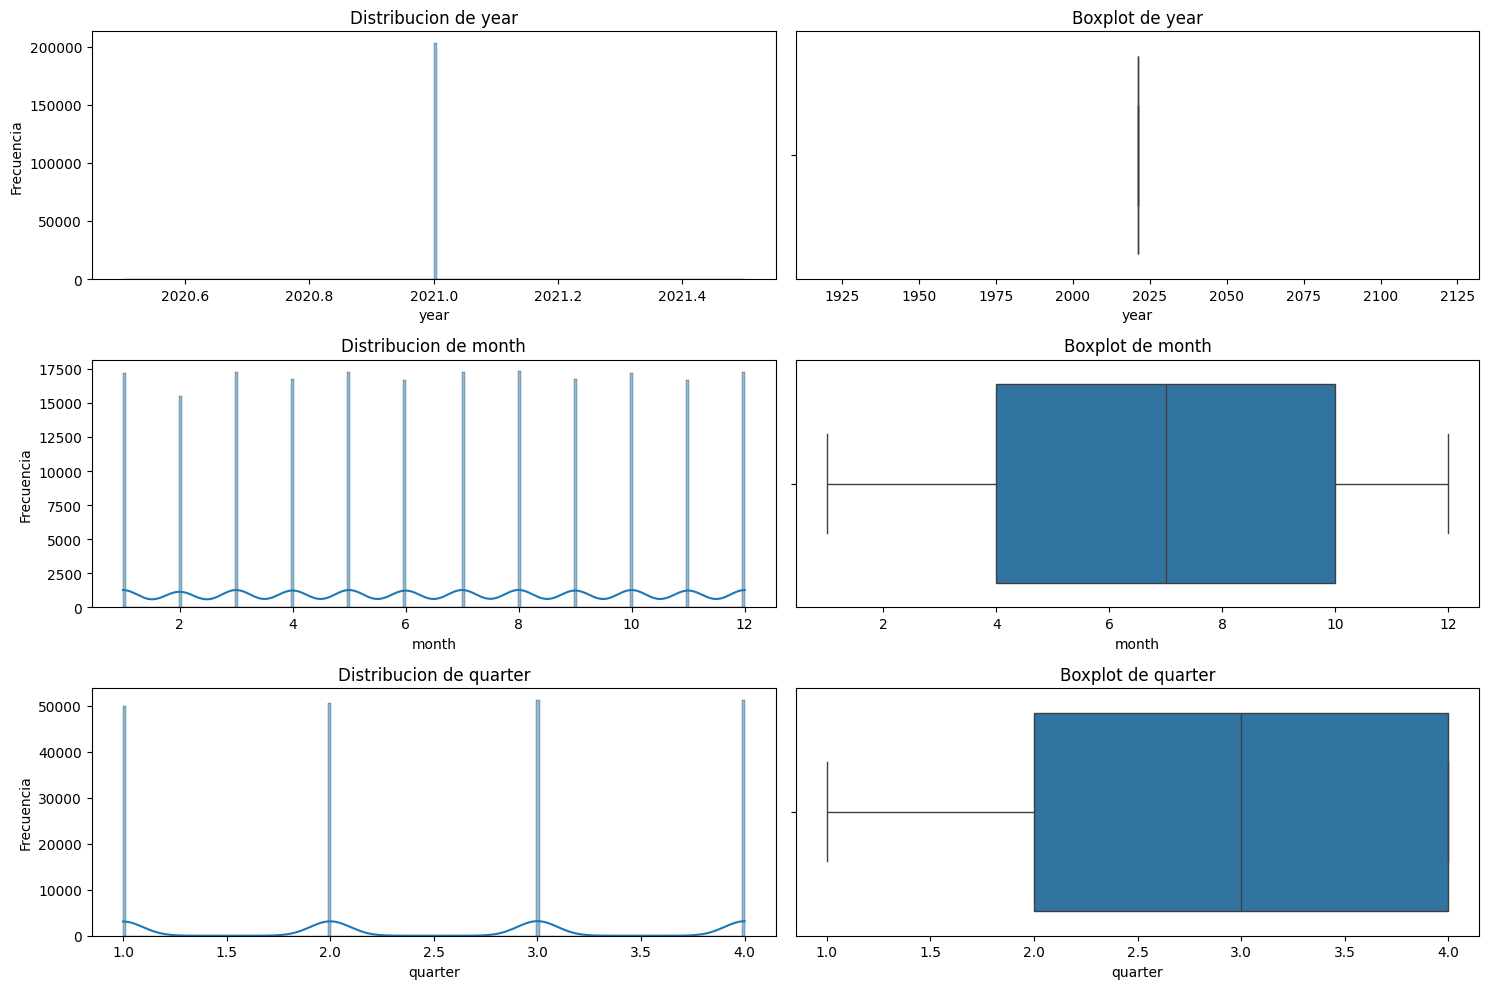

In [11]:
lista_col_fechas = ['year', 'month', 'quarter'] # Columnas de fechas
spv.subplot_col_num(df, lista_col_fechas) # Visualizamos las columnas de fechas

In [12]:
df[lista_col_fechas].describe().T # Resumen estadístico

,count,mean,std,min,25%,50%,75%,max
year,203007.0000,2021.0000,0.0000,2021.0000,2021.0000,2021.0000,2021.0000,2021.0000
month,203007.0000,6.5275,3.4465,1.0000,4.0000,7.0000,10.0000,12.0000
quarter,203007.0000,2.5101,1.1162,1.0000,2.0000,3.0000,4.0000,4.0000


# Gestion de nulos de las columnas numericas

In [13]:
total_nulos, porcentaje_total_nulos = sp.calcular_nulos(df) # Calculamos los nulos

In [14]:
col_high_umbral, col_low_umbral = snulos.calcular_solo_col_nul(df, 5) # Calculamos las columnas con nulos

,Column,Datatype,NullCount,Null%
0,duration,float64,18606,8.8636
1,conversion_rate,float64,9444,4.4990
2,roi,float64,36476,17.3766
3,clicks,float64,31274,14.8984
4,impressions,float64,21462,10.2241
5,engagement_score,float64,23864,11.3684
6,total($),float64,8083,3.8506
7,year,float64,6908,3.2909
8,month,float64,6908,3.2909
9,quarter,float64,6908,3.2909


## Empezamos a gestionar nulos: columnas con un % de nulos inferior al umbral
- El umbral establecido es 5%
- El metodo para imputar nulos va a ser fillna()

In [15]:
col_low_umbral

['conversion_rate', 'total($)', 'year', 'month', 'quarter']

In [16]:
# Rellenamos los nulos de las columnas con menos del 5% de nulos creando un df nuevo
df_filled_simple = df.fillna({
  "conversion_rate": df["conversion_rate"].mean(),
  "total($)": df["total($)"].mean(),
  "year": 2021,
  "month": df["month"].median(),
  "quarter": 3
})

In [17]:
snulos.calcular_solo_col_nul(df_filled_simple[col_low_umbral]) # Comprobamos que no hay nulos en las columnas con menos del 5% de nulos

,Column,Datatype,NullCount,Null%


([], [])

In [18]:
# Comprobar como cambian mis estadisticos al rellenar nulos
# Describe del df nuevo
df_filled_simple[col_low_umbral].describe().T

,count,mean,std,min,25%,50%,75%,max
conversion_rate,209915.0000,0.0808,0.0401,0.0100,0.0500,0.0808,0.1111,0.1515
total($),209915.0000,12503.9995,4253.8506,5000.0000,8886.0000,12503.9995,16118.0000,20000.0000
year,209915.0000,2021.0000,0.0000,2021.0000,2021.0000,2021.0000,2021.0000,2021.0000
month,209915.0000,6.5431,3.3904,1.0000,4.0000,7.0000,9.0000,12.0000
quarter,209915.0000,2.5262,1.1012,1.0000,2.0000,3.0000,3.0000,4.0000


In [19]:
# Describe del df original
df[col_low_umbral].describe().T

,count,mean,std,min,25%,50%,75%,max
conversion_rate,200471.0000,0.0808,0.0410,0.0100,0.0500,0.0808,0.1200,0.1515
total($),201832.0000,12503.9995,4338.1943,5000.0000,8740.0000,12496.0000,16261.0000,20000.0000
year,203007.0000,2021.0000,0.0000,2021.0000,2021.0000,2021.0000,2021.0000,2021.0000
month,203007.0000,6.5275,3.4465,1.0000,4.0000,7.0000,10.0000,12.0000
quarter,203007.0000,2.5101,1.1162,1.0000,2.0000,3.0000,4.0000,4.0000


Comprobamos cambios minimos en los estadisticos. Procedemos a gestionar los nulos de nuestro df, con el que estamos trabajando, como hemos hecho en el df_filled_simple

In [20]:
# Rellenamos los nulos de las columnas con menos del 5% de nulos del df original
df = df.fillna({
  "conversion_rate": df["conversion_rate"].mean(),
  "total($)": df["total($)"].mean(),
  "year": 2021,
  "month": df["month"].median(),
  "quarter": 3
})

In [21]:
# Describe del df original
df[col_low_umbral].describe().T

,count,mean,std,min,25%,50%,75%,max
conversion_rate,209915.0000,0.0808,0.0401,0.0100,0.0500,0.0808,0.1111,0.1515
total($),209915.0000,12503.9995,4253.8506,5000.0000,8886.0000,12503.9995,16118.0000,20000.0000
year,209915.0000,2021.0000,0.0000,2021.0000,2021.0000,2021.0000,2021.0000,2021.0000
month,209915.0000,6.5431,3.3904,1.0000,4.0000,7.0000,9.0000,12.0000
quarter,209915.0000,2.5262,1.1012,1.0000,2.0000,3.0000,3.0000,4.0000


## Empezamos a gestionar nulos: columnas con un % de nulos superior al umbral
- El umbral establecido es 5%
- El metodo para imputar nulos va a ser iterativeimputer

In [24]:
def imputar_iterative(df, lista_columnas):
  """
  Función que rellena los nulos de un dataframe con el método IterativeImputer
  """
  iter_imputer = IterativeImputer(max_iter=50, random_state=42) # Creamos el objeto IterativeImputer
  data_imputed = iter_imputer.fit_transform(df[col_high_umbral]) # Rellenamos los nulos con el objeto IterativeImputer
  new_col = [col + "_iterative" for col in lista_columnas] # Creamos una lista con los nombres de las nuevas columnas
  df[new_col] = data_imputed # Añadimos las nuevas columnas al dataframe
  display(df[new_col].describe().T) # Mostramos el resumen estadístico de las nuevas columnas
  return df, new_col

In [25]:
df, col_iterative = imputar_iterative(df, col_high_umbral) # Rellenamos los nulos de las columnas con más del 5% de nulos

,count,mean,std,min,25%,50%,75%,max
duration_iterative,209915.0000,37.5035,15.9850,15.0000,30.0000,37.5220,45.0000,60.0000
roi_iterative,209915.0000,27.5299,23.8083,2.0000,5.6400,27.2071,44.3737,88.0000
clicks_iterative,209915.0000,275083.7669,304720.3894,100.0000,630.0000,256256.0000,470470.0000,999999.0000
impressions_iterative,209915.0000,27542117.2004,31359913.9309,1000.0000,6015.0000,20252025.0000,50095009.0000,99999999.0000
engagement_score_iterative,209915.0000,77.9071,203.1876,1.0000,6.0000,22.0000,77.0000,1010.0000


In [ ]:
df[col_high_umbral].describe().T # Resumen estadístico de las columnas con más del 5% de nulos

,count,mean,std,min,25%,50%,75%,max
duration,191309.0000,37.5035,16.7443,15.0000,30.0000,30.0000,45.0000,60.0000
roi,173439.0000,27.5304,26.1923,2.0000,5.0100,8.0000,55.0000,88.0000
clicks,178641.0000,275083.8650,330318.3401,100.0000,551.0000,100100.0000,548548.0000,999999.0000
impressions,188453.0000,27542118.3142,33097499.8431,1000.0000,5508.0000,9996.0000,55225522.0000,99999999.0000
engagement_score,186051.0000,77.9064,215.8253,1.0000,5.0000,10.0000,66.0000,1010.0000


In [27]:
# Despues de comprobar los estadisticos, eliminamos las columnas con nulos
df.drop(columns = col_high_umbral, inplace = True) # Eliminamos las columnas con más del 5% de nulos

In [28]:
df.to_csv('../data/data_limpios.csv', index = False) # Guardamos el dataset limpio